In [23]:
# Built-in dependencies
import copy 

# External dependencies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


# Constants
N: int = 3
NAV: float = 45_883.87  # 43_964.16
TARGET_LEVERAGE: float = 1.40  # 2.20
LEVERAGE: np.ndarray = np.array(
    [
        [1.00],
        [2.00],
        [3.00]
    ]
)
EXPENSE_RATIOS: np.ndarray = np.array(
    [
        [0.0002],  # SPLG
        [0.0061],  # SPUU
        [0.0091]   # UPRO 
    ]
)
EXPENSE_RATIO_ADJUSTED_LEVERAGE: np.ndarray = LEVERAGE - EXPENSE_RATIOS

In [24]:
def relu_upper_bound(x: np.ndarray, bound: float) -> np.ndarray:

    relu = np.dot(np.transpose(x), np.ones(np.shape(x))) - bound
    
    return np.log(relu) if relu > 0.00 else 0.00


def relu_upper_bound_gradient(x: np.ndarray, bound: float) -> np.ndarray:

    relu = np.dot(np.transpose(x), np.ones(np.shape(x))) - bound
    
    return 1 / x if relu > 0.00 else 0.00


def element_wise_relu_lower_bound(x: np.ndarray, bound: float) -> np.ndarray:

    x = copy.deepcopy(x)

    inactive_index = np.where(x >= bound)
    active_index = np.where(x < bound)
    
    x[inactive_index] = 0
    x[active_index] = np.log(-x[active_index])
    
    return x


def element_wise_relu_lower_bound_gradient(x: np.ndarray, bound: float) -> np.ndarray:

    x = copy.deepcopy(x)

    inactive_index = np.where(x >= bound)
    active_index = np.where(x < bound)
    
    x[inactive_index] = 0
    x[active_index] = 1 / -x[active_index]
    
    return x


def min_t_cost_constrained_optimizer(
    weights: np.ndarray, 
    leverage: np.ndarray, 
    expense_ratios: np.ndarray,
    learning_rate: float = 0.001,
    n_iterations: int = 200_000,
    bound_penalty: float = 0.01,
    stochastic_factor: float = 0.00
) -> np.ndarray:
    
    weights_evolution = []
    objective_evolution = []
    
    for i in range(n_iterations):
        
        objective = (
            np.dot(np.transpose(weights), expense_ratios)
            + np.square(np.dot(np.transpose(weights), leverage) - TARGET_LEVERAGE)
            - bound_penalty * relu_upper_bound(x=weights, bound=1)
            - bound_penalty * np.dot(np.transpose(element_wise_relu_lower_bound(x=weights, bound=0)), np.ones(np.shape(weights)))
        )
        objective_evolution.append(objective[0][0])

        gradient = (
            expense_ratios
            + 2 * (np.dot(np.transpose(weights), leverage) - TARGET_LEVERAGE) * leverage
            + bound_penalty * relu_upper_bound_gradient(x=weights, bound=1)  # add to gradient which will be subtracted from weights - go back below upper bound
            - bound_penalty * element_wise_relu_lower_bound_gradient(x=weights, bound=0)  # subtract from gradient which will be added to weights - go back above lower bound
        )

        # Simulate a noisy gradient - decrease the magnitude of the noise over time
        gradient = gradient + np.random.normal(
            loc=0.0, 
            scale=stochastic_factor * (1 - i / n_iterations) * np.mean(np.abs(gradient)), size=np.shape(weights)
        )
        
        weights = weights - learning_rate * gradient

        weights_evolution.append(weights)
    
    pd.Series(objective_evolution).plot()
    plt.show()

    return weights_evolution[np.argmin(objective_evolution)], np.min(objective_evolution)

# Ensemble Randomized Optimization

In [39]:
n_random_initial_weights: int = 10
random_initial_weights = np.random.uniform(low=0, high=1, size=(n_random_initial_weights, 3))
random_initial_weights /= np.reshape(np.sum(random_initial_weights, axis=1), newshape=(n_random_initial_weights, 1))
random_initial_weights /= 2
random_initial_weights

array([[0.14384487, 0.31100711, 0.04514802],
       [0.12968053, 0.26187554, 0.10844393],
       [0.13734531, 0.10559198, 0.25706271],
       [0.19190582, 0.07462969, 0.23346449],
       [0.33424726, 0.07567337, 0.09007937],
       [0.2712582 , 0.14251489, 0.08622691],
       [0.1450425 , 0.11941137, 0.23554612],
       [0.13617003, 0.16320671, 0.20062326],
       [0.05025784, 0.03482366, 0.4149185 ],
       [0.44120266, 0.01293355, 0.04586379]])

To mitigate the effects of local minima, randomize a panel of initial weights, and run the optimization for each random initial weights vector. 

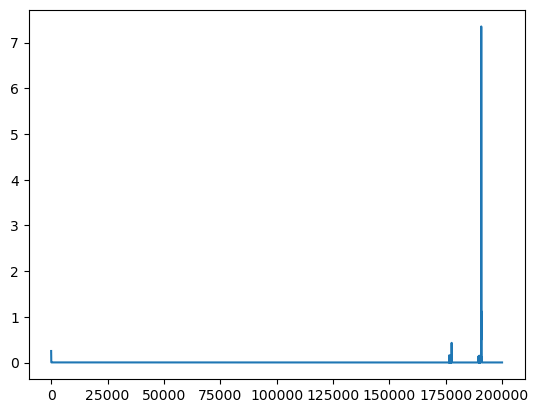

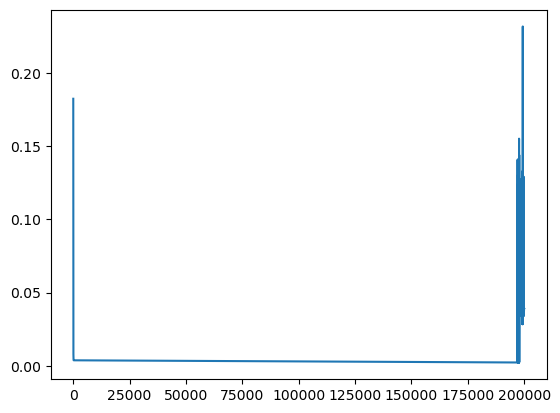

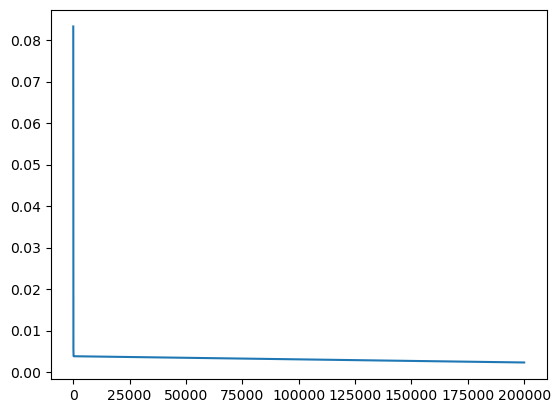

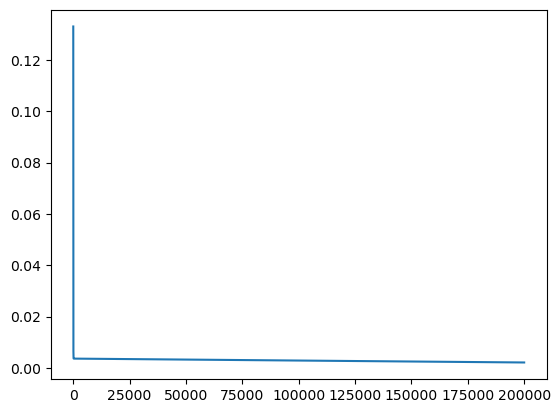

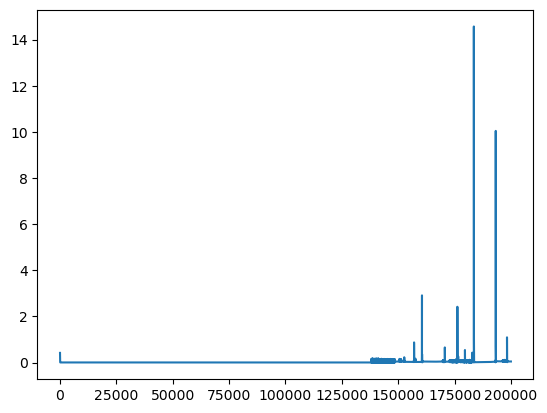

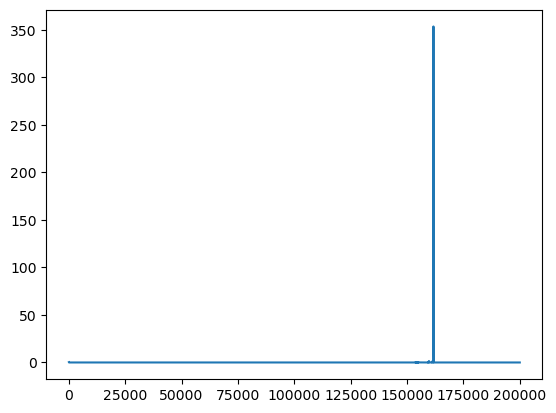

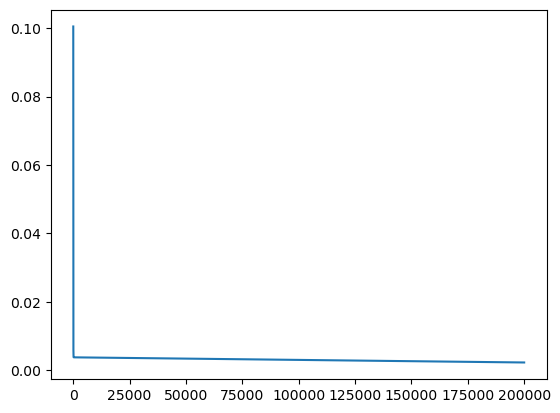

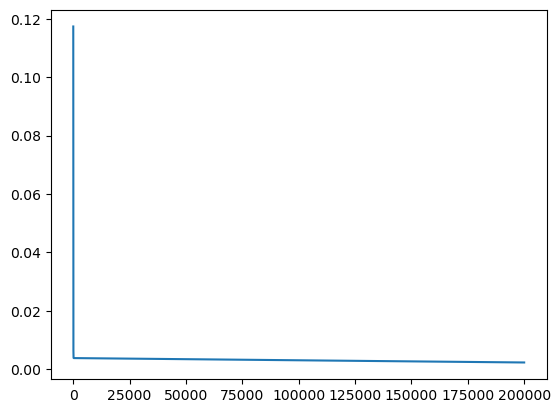

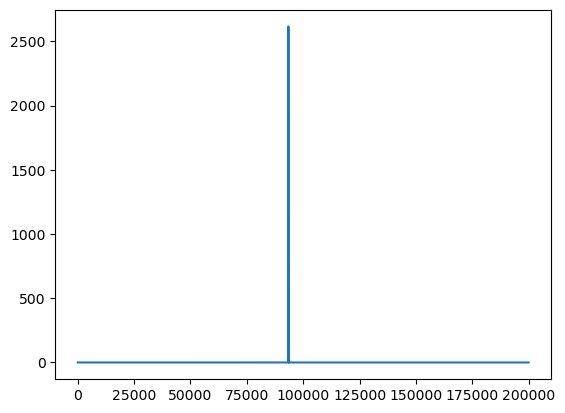

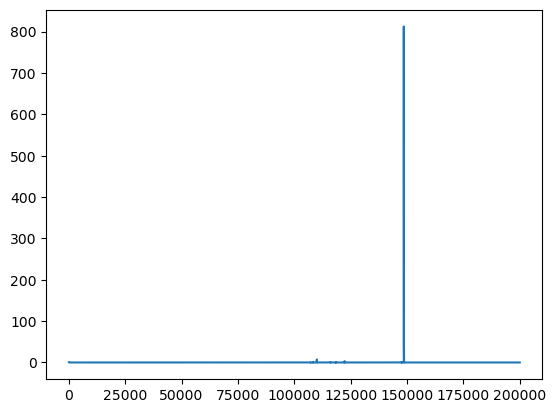

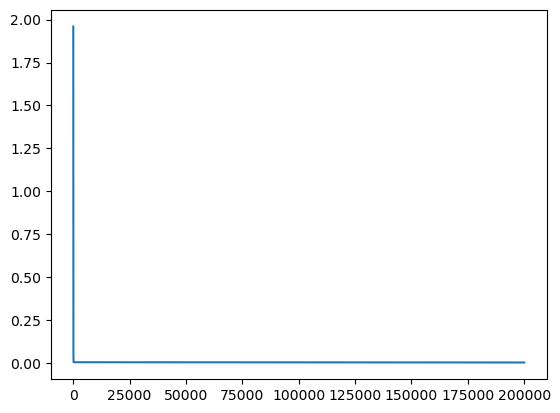

,0,1,2
0,0.665367,0.269109,0.065533
1,0.681166,0.237448,0.081395
2,0.686124,0.059792,0.198393
3,0.746270,0.039969,0.191503
4,0.799495,0.001397,0.199116
5,0.695911,0.077780,0.183129
6,0.688906,0.125299,0.153792
7,0.628981,0.114149,0.181257


In [40]:
solution_weights = []
solution_objectives = []

for i, random_initial_weights_i in enumerate(random_initial_weights):

    random_initial_weights_i = np.reshape(random_initial_weights_i, newshape=(-1, 1))
    
    solution_weights_i, solution_objective_i = min_t_cost_constrained_optimizer(
        weights=random_initial_weights_i, 
        leverage=EXPENSE_RATIO_ADJUSTED_LEVERAGE, 
        expense_ratios=EXPENSE_RATIOS
    )

    if np.any(solution_weights_i < 0):
        continue

    solution_weights.append(solution_weights_i.flatten())
    solution_objectives.append(solution_objective_i)

solution_weights_i, solution_objective_i = min_t_cost_constrained_optimizer(
    weights=np.array([[0.00], [0.00], [0.00]]), 
    leverage=EXPENSE_RATIO_ADJUSTED_LEVERAGE, 
    expense_ratios=EXPENSE_RATIOS
)

solution_weights.append(solution_weights_i.flatten())
solution_objectives.append(solution_objective_i)

solution_weights = pd.DataFrame(solution_weights)
solution_weights

In [41]:
solution_weights = pd.DataFrame(solution_weights)
solution_weights

,0,1,2
0,0.665367,0.269109,0.065533
1,0.681166,0.237448,0.081395
2,0.686124,0.059792,0.198393
3,0.746270,0.039969,0.191503
4,0.799495,0.001397,0.199116
5,0.695911,0.077780,0.183129
6,0.688906,0.125299,0.153792
7,0.628981,0.114149,0.181257


In [42]:
index = np.where(np.array(solution_objectives) > 0)

filtered_solution_objectives = np.array(solution_objectives)[index]
filtered_solution_weights = solution_weights.iloc[index]

filtered_solution_weights

,0,1,2
0,0.665367,0.269109,0.065533
1,0.681166,0.237448,0.081395
2,0.686124,0.059792,0.198393
3,0.746270,0.039969,0.191503
4,0.799495,0.001397,0.199116
5,0.695911,0.077780,0.183129
6,0.688906,0.125299,0.153792
7,0.628981,0.114149,0.181257


In [43]:
optimal_weights = filtered_solution_weights.iloc[np.argmin(filtered_solution_weights.dot(EXPENSE_RATIO_ADJUSTED_LEVERAGE))]
optimal_weights

0    0.799495
1    0.001397
2    0.199116
Name: 4, dtype: float64

In [44]:
optimal_weights.dot(LEVERAGE)[0]

1.399637358237819

In [45]:
optimal_dollar_weights = NAV * optimal_weights.round(2)
optimal_dollar_weights

0    36707.096
1        0.000
2     9176.774
Name: 4, dtype: float64

# Manual Optimization

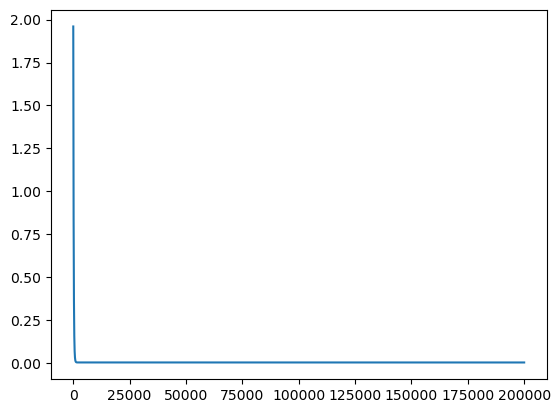

(array([[0.15330071],
        [0.19170463],
        [0.28856481]]),
 0.6335701412485581,
 array([[1.39857838]]),
 array([[0.003826]]))

In [46]:
learning_rate: float = 0.0001

weights, objective = min_t_cost_constrained_optimizer(
    weights=np.array([[0.00], [0.00], [0.00]]), 
    leverage=EXPENSE_RATIO_ADJUSTED_LEVERAGE, 
    expense_ratios=EXPENSE_RATIOS,
    learning_rate=learning_rate,
    bound_penalty=0.001
)
weights, weights.sum(), weights.T.dot(EXPENSE_RATIO_ADJUSTED_LEVERAGE), weights.T.dot(EXPENSE_RATIOS)

In [47]:
weights

array([[0.15330071],
       [0.19170463],
       [0.28856481]])

In [48]:
weights.T.dot(EXPENSE_RATIO_ADJUSTED_LEVERAGE)

array([[1.39857838]])

In [49]:
weights.T.dot(EXPENSE_RATIO_ADJUSTED_LEVERAGE)

array([[1.39857838]])

In [50]:
weights.T.dot(EXPENSE_RATIOS)

array([[0.003826]])

In [51]:
manual_weights = np.array(
    [
        [0.80],
        [0.0],
        [0.20]
    ]
)

manual_weights.T.dot(EXPENSE_RATIO_ADJUSTED_LEVERAGE), manual_weights.T.dot(EXPENSE_RATIOS)

(array([[1.39802]]), array([[0.00198]]))